## The Plan
- Load and prep the data (remove useless and highly correlated features)
- Split data randomly into train and test sets (80/20 split).
  - I did try a sequential split where data form the last 2 months were held out as a test set, and I used the previous historical data to forecast it. The results were close to random split, but a bit worse. Looking at the EDA notebook, this could be because the last 4 months in 2020 were a bit in flux then in 2021 things seemed to stabalize a bit.
- Apply `log1p` normalization to $y$, the regression label: $\,\left(\text{log1p}(y) - \mu\right) / \sigma$ to stabalize the variance and work with real-values instead of positive values, and a more numerically stable range for regression.
- Fit a CatBoostRegressor using its default hyperparameter values and obtain performance metrics on the test dataset.
- Do hyperparameter tuning on some hyperparameter using 3-fold cross-validation
- Pick the winner based on accuracy and obtain its performance metrics (slighly better than default values) on the test dataset.

## Model Metrics
After some hyperparameter tuning, the "winning" model has these performance metric values on the test set:
- **Transformed scale** (RMSE: 0.2908, MAE: 0.1565, $R^2$: 0.9300, SpearmanR: 0.9515)
- **Original scale** (RMSE: 1880.3673, MAE: 806.4776, $R^2$: 0.8252, SpearmanR: 0.9515)

## References:
- https://catboost.ai/en/docs/concepts/python-reference_catboostregressor
- https://catboost.ai/en/docs/references/training-parameters/common
- https://catboost.ai/en/docs/concepts/parameter-tuning
- https://catboost.ai/en/docs/concepts/python-reference_catboostregressor_grid_search
- https://catboost.ai/en/docs/concepts/python-usages-examples


In [1]:
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

from utils import (get_train_test_sets, 
                   transform_regression_label,
                   inverse_transform_regression_label,
                   fit_default_catboostregressor_model,
                   plot_feature_importances,
                   evaluate_regression_performance) 


## Load and preprocess the data

In [2]:
data = pd.read_csv('data/dataset.csv')
data.shape

(4350, 314)

In [3]:
# To get a handle on multicolinearity, we drop some columns
with open('drop_features.pickle', 'rb') as f:
    # Load the data back into a list
    drop_features = pickle.load(f)
# drop useless features
data = data.drop(drop_features, axis=1)
data.shape

(4350, 275)

In [4]:
categorical_features = list(data.select_dtypes(include=['object']).columns)
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

## Inspect results from CatBoostRegressor using its default hyperparameter values

Transformed scale (RMSE: 0.3102, MAE: 0.1767, R2: 0.9203, SpearmanR: 0.9409)
Original scale (RMSE: 2058.5213, MAE: 938.3208, R2: 0.7906, SpearmanR: 0.9409)




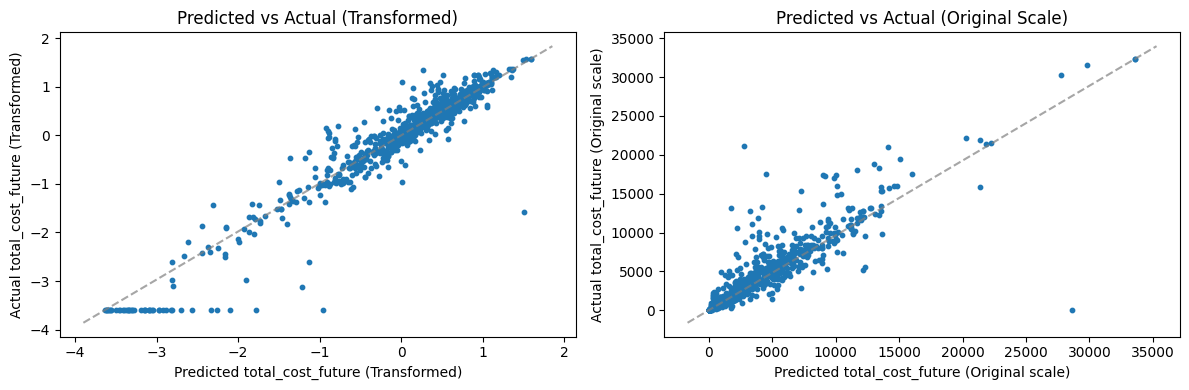

In [5]:
X_train, X_test, y_train_raw, y_test_raw = get_train_test_sets(data, 'total_cost', 
                                                       'date', test_size=0.20,
                                                       split_type='Random')
MEAN = np.mean(np.log1p(y_train_raw))
SD = np.std(np.log1p(y_train_raw))

y_train = transform_regression_label(y_train_raw, MEAN, SD)
y_test = transform_regression_label(y_test_raw, MEAN, SD)


np.testing.assert_allclose(inverse_transform_regression_label(y_train, MEAN, SD), y_train_raw)
np.testing.assert_allclose(inverse_transform_regression_label(y_test, MEAN, SD), y_test_raw)

model, RMSE_raw, MAE_raw, R2_raw, SpearR_raw = fit_default_catboostregressor_model(X_train, X_test, y_train, y_test, 
                                                                                   y_test_raw, MEAN, SD, categorical_features)

In [6]:
print('Some default model parameter values:')
params = ['depth', 'learning_rate', 'l2_leaf_reg', 'iterations']
[(p, model.get_all_params()[p]) for p in params]

Some default model parameter values:


[('depth', 6),
 ('learning_rate', 0.04986000061035156),
 ('l2_leaf_reg', 3),
 ('iterations', 1000)]

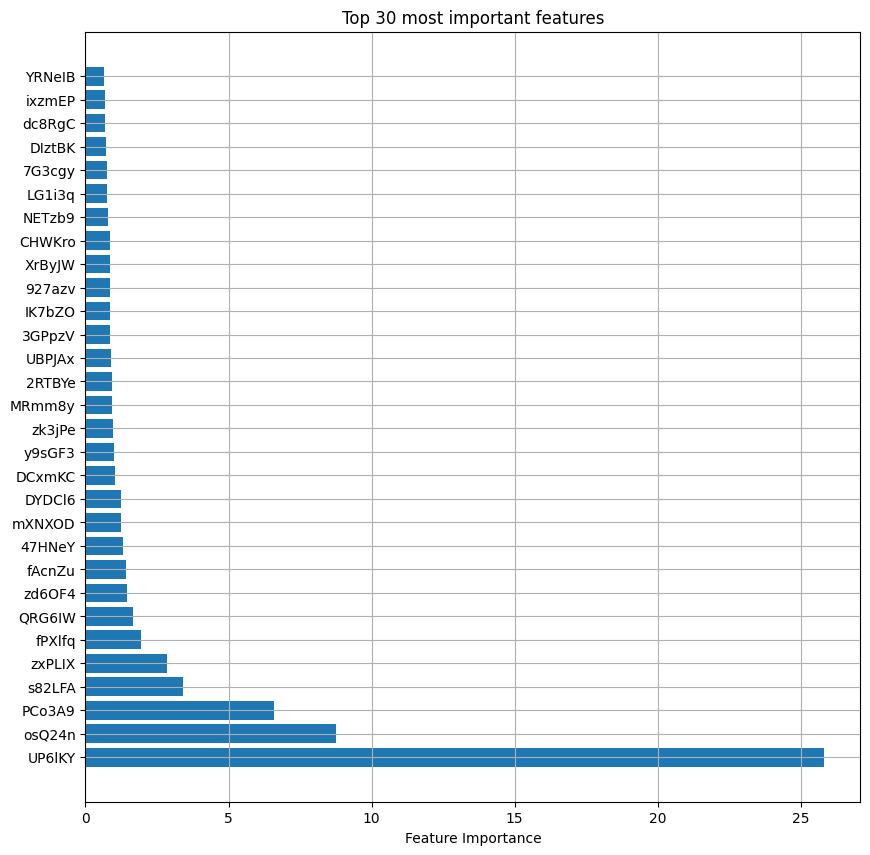

In [7]:
# Inspect feature importances (plot top 30)
_ = plot_feature_importances(model)

## Hyperparameter tuning
A simple grid search over specified parameter values and using 3-fold cross-validation to decide on the winning combo.

In [8]:
# This cell takes a few minutes to run

# Define a grid over hyperparameter
param_grid = {
    'learning_rate': [0.01, 0.025, 0.05],
    'depth': [4, 6, 7],
    'l2_leaf_reg': [2, 3, 4],
    'iterations': [250, 500, 1000],
}

# Create a CatBoostClassifier object
model = CatBoostRegressor(loss_function='RMSE', silent=True, random_state=42, cat_features=categorical_features)
model.randomized_search(param_grid, X=X_train, y=y_train, cv=3, plot=False, verbose=False)

# Extract the best parameters
params = ['depth', 'learning_rate', 'l2_leaf_reg', 'iterations']
best_params = [(p, model.get_params()[p]) for p in params]
# Print the best parameters
print(f'\nBest Parameters: {best_params}\n')


bestTest = 0.6066225357
bestIteration = 249


bestTest = 0.5677964392
bestIteration = 999


bestTest = 0.5923954461
bestIteration = 249


bestTest = 0.4771322622
bestIteration = 249


bestTest = 0.5093808061
bestIteration = 249


bestTest = 0.5292174093
bestIteration = 499


bestTest = 0.4321131683
bestIteration = 499


bestTest = 0.3230376002
bestIteration = 497


bestTest = 0.3533686846
bestIteration = 499


bestTest = 0.2584903018
bestIteration = 999

Training on fold [0/3]

bestTest = 0.3551593265
bestIteration = 999

Training on fold [1/3]

bestTest = 0.374518497
bestIteration = 999

Training on fold [2/3]

bestTest = 0.3114297677
bestIteration = 999


Best Parameters: [('depth', 7), ('learning_rate', 0.05), ('l2_leaf_reg', 3), ('iterations', 1000)]



## Inpsect results from a tuned CatBoostRegressor model

Transformed scale (RMSE: 0.2908, MAE: 0.1565, R2: 0.9300, SpearmanR: 0.9515)
Original scale (RMSE: 1880.3673, MAE: 806.4776, R2: 0.8252, SpearmanR: 0.9515)




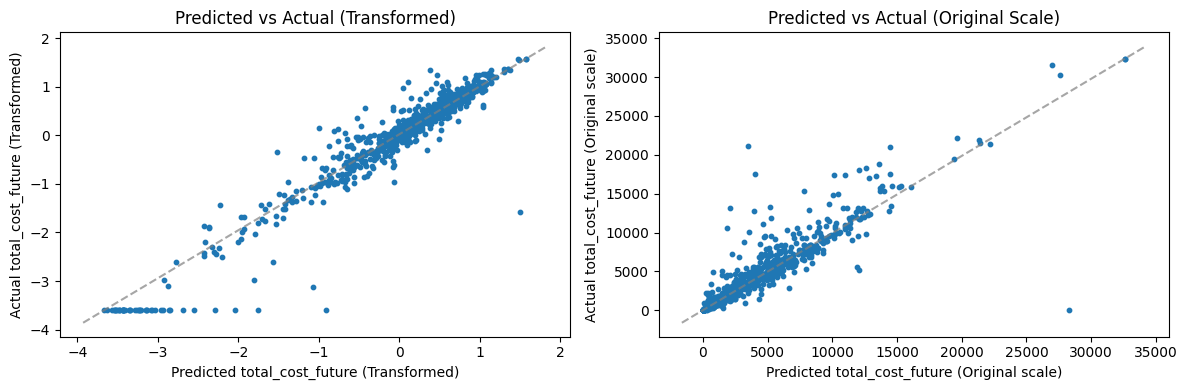

In [9]:
# evaluate best model performance on "unseen" data (my test set)
y_pred = model.predict(X_test)
y_pred_raw = inverse_transform_regression_label(y_pred, MEAN, SD)

_ = evaluate_regression_performance(y_test, y_pred, X_test, y_test_raw, y_pred_raw)

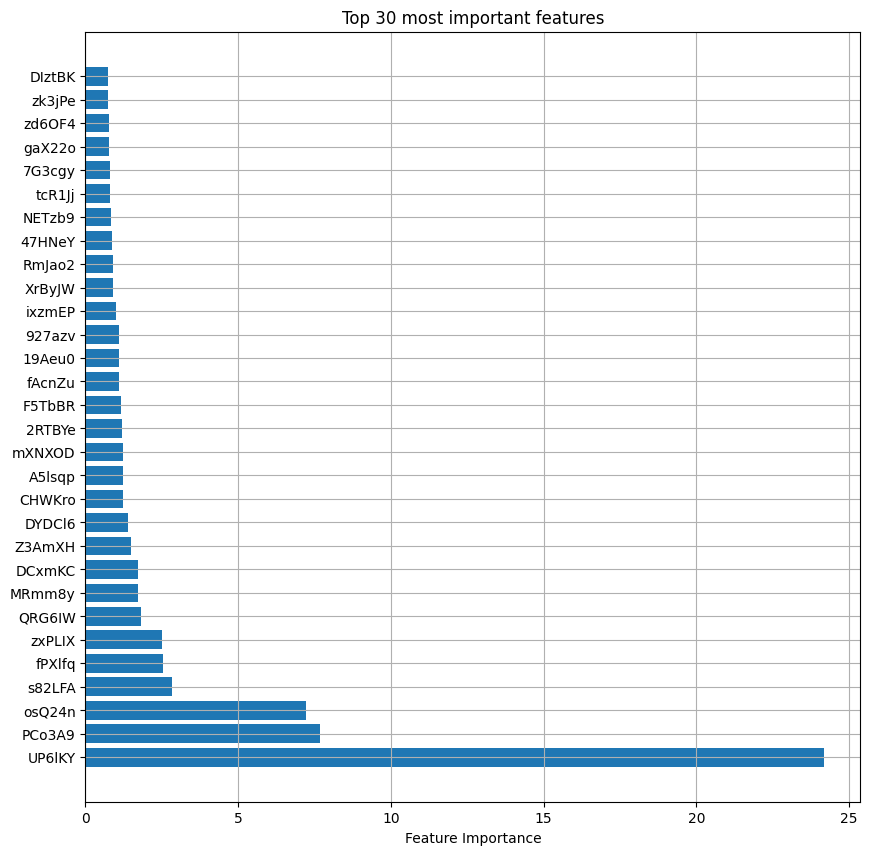

In [10]:
# inspect feature importance 
_ = plot_feature_importances(model)